In [4]:
import sys
import subprocess
import json
import os
import matplotlib.pyplot as plt
from functools import reduce


sys.path.append(os.path.abspath("../generation"))
import generate
from parseRePEAT import *

In [5]:
def plot_atf(segments, label, color, eatfs, fig, axs):
    line = None
    for (x0, x1, y0, y1) in segments:
        if x0 == "-inf" and x1 != "inf" and y1 != "inf":
            axs[0].hlines(float(y1), 0, float(x1), colors=color)
        line, = axs[0].plot([float(x0), float(x1)], [float(y0), float(y1)], color=color)
    line.set_label(label) if line is not None else None

    for (zeta, alpha, beta, delta, gammas) in list(eatfs.values())[0]:
        min_gammas = [float(gamma[0]) for gamma in gammas]
        min_gamma = sum(min_gammas)

        length_edge = float(beta)-float(alpha)
        max_gammas = [min(float(gamma[1]), length_edge + float(gamma[0])) for gamma in gammas]
        max_gamma = sum(max_gammas)
        axs[1].plot([float(alpha), float(beta)], [min_gamma, max_gamma], color=color)
        # axs[1].plot([float(alpha), float(beta)], [min_gammas, max_gammas], color=color)

        print(f"{alpha}, {beta}, {gammas}, {min_gamma} - {max_gamma}")

def generate_intervals(max_buffer, use_recovery_time, layout, scenario, agent, agent_speed, move, fig, axs, color):
    # Generate intervals
    generate.time_safe_intervals_and_write(layout, scenario, agent["trainNumber"], agent_speed, "output", max_buffer, use_recovery_time)
    # generate.time_safe_intervals_and_write(layout, scenario, -1, 30, "output", max_buffer)
    # start = "r-n3_2" if agent["trainNumber"] == 1 else "t-n3_1"
    start = "r-n3_2"
    timeout = 10
    try:
        # proc = subprocess.run(["atsipp.exe", "--start", start, "--goal", "r-14", "--edgegraph", "output", "--search", "repeat", "--startTime", str(move["startTime"])], timeout=20, stdout=subprocess.PIPE, stderr=subprocess.DEVNULL)
        proc = subprocess.run(["Y:/Uni/Thesis/executable/atsipp.exe", "--start", start, "--goal", "r-14", "--edgegraph", "output", "--search", "repeat", "--startTime", str(move["startTime"])], timeout=timeout, stdout=subprocess.PIPE, stderr=subprocess.DEVNULL)

    except subprocess.TimeoutExpired:
        print(f'Timeout for repeat ({timeout}s) expired')
        return
    repeat_output = str(proc.stdout).split("'")[1].rsplit("\\r\\n")

    # If the run was successful
    if int(proc.returncode) == 0:
        metadata, catf, paths, eatfs = parse_list_of_outputs(repeat_output)
        # print(f"eats: {eatfs}")
        # print(f"cats: {catf}")
        label = f"{max_buffer} seconds buffer time" if max_buffer > 0 else "No flexibility"
        plot_atf(catf, label, color, eatfs, fig, axs)

50, 538.578, [['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0']], 0.0 - 0.0
538.578, 560.746, [['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0']], 0.0 - 0.0
560.746, 560.746, [['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0']], 0.0 - 0.0
560.746, 564.45, [['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0']], 0.0 - 0.0
564.45, 565.746, [['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0']], 0.0 - 0.0
565.746, 591.617, [['0', '0', '0'], ['0', '0', '0'], ['0', '23.4098', '0'], ['0', '0', '0'], ['0', '0', '0']], 0.0 - 23.4098
591.617, 591.617, [['0', '0', '0'], ['0', '0', '0'], ['23.4098', '23.4098', '0'], ['0', '0', '0'], ['0', '0', '0']], 23.4098 - 23.4098
591.617, 595.321, [['0', '0', '0'], ['0', '0', '0'], ['23.4098', '27.1135', '0'], ['0', '0', '0'], ['0', '0', '0']], 23.4098 - 27.1135
595.321, 799.467, [['0', '0', '0'], [

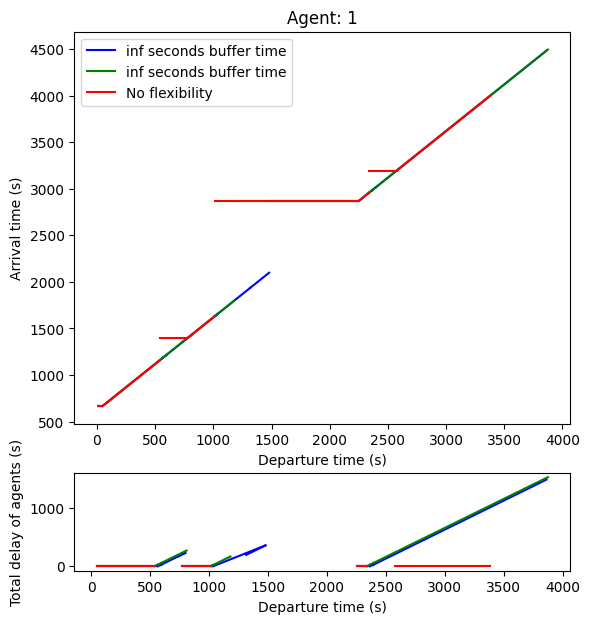

600, 1013.58, [['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0']], 0.0 - 0.0
1013.58, 1019.45, [['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0']], 0.0 - 0.0
1019.45, 1022.04, [['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0']], 0.0 - 0.0
1022.04, 1027.91, [['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0']], 0.0 - 0.0
1027.91, 1035.32, [['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0']], 0.0 - 0.0
1035.32, 1479.56, [['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '360', '0'], ['0', '0', '0']], 0.0 - 360.0
1315.45, 1479.56, [['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['195.891', '360', '0'], ['0', '0', '0']], 195.891 - 360.0
2252.61, 2338.58, [['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0']], 0.0 - 0.0
2338.58, 2360.75, [['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0

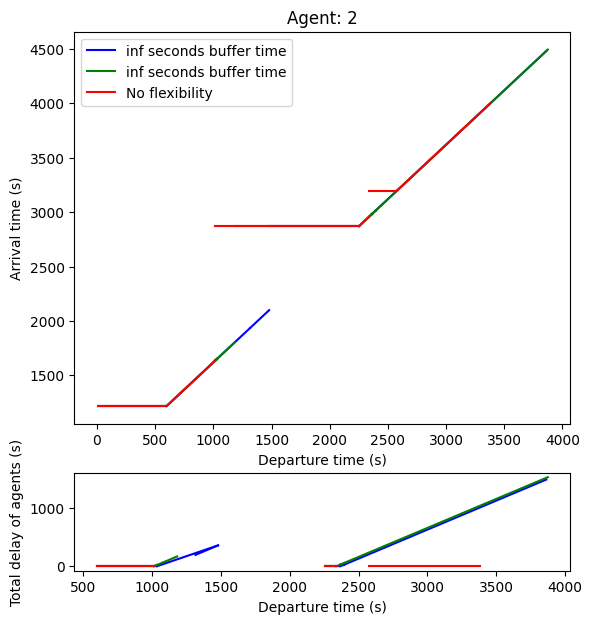

900, 1756.47, [['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0']], 0.0 - 0.0
1756.47, 1798.21, [['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '41.7431', '0']], 0.0 - 41.74000000000001
1798.21, 1839.95, [['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['41.7431', '83.4862', '0']], 41.7431 - 83.48310000000001
1839.95, 1881.7, [['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['83.4862', '125.229', '0']], 83.4862 - 125.229
1881.7, 1923.44, [['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['125.229', '166.972', '0']], 125.229 - 166.969
1923.44, 1965.18, [['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['166.972', '208.716', '0']], 166.972 - 208.71200000000002
1965.18, 2006.93, [['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['208.716', '250.459', '0']], 208.716 - 250.459
2006.93, 2048.67, [['0', '0', '0'], ['0', '0', '0'], ['0', '

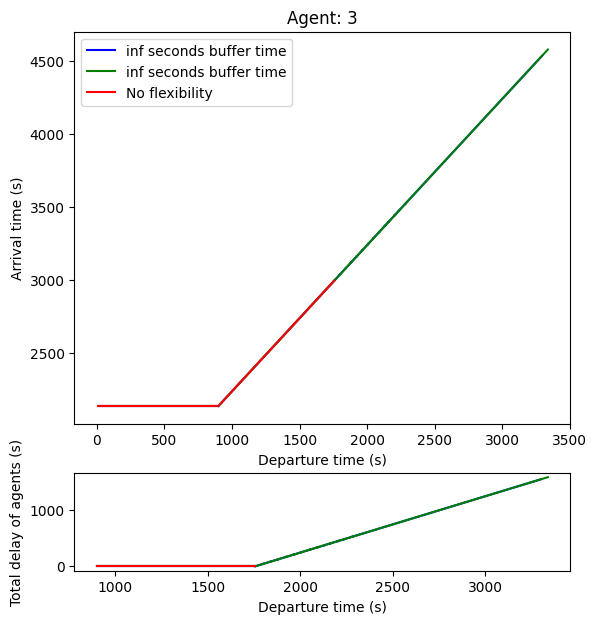

2400, 3380.73, [['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0']], 0.0 - 0.0
2400, 3380.73, [['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0']], 0.0 - 0.0
2400, 3380.73, [['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0']], 0.0 - 0.0


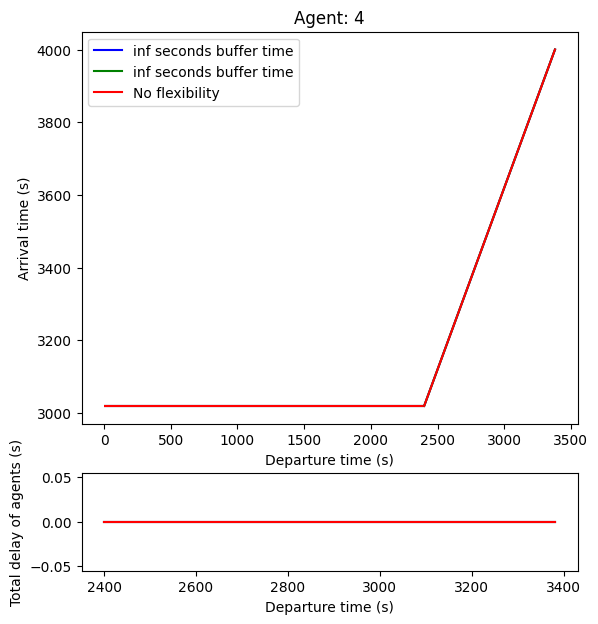

In [8]:
# Run RePeAT to get multiple plans
scenario = "../data/single_track/scenario_following.json"
layout =   "../data/single_track/woho.json"

scenario_data = json.load(open(scenario))
train_types = {x["name"]: x for x in scenario_data["types"]}
for agent in scenario_data['trains']:
    # Get the global end time of scenario
    scenario_end_time = 0
    for i in range(len(agent["movements"])):
        move = agent["movements"][i]
        if 2 * move["endTime"] > scenario_end_time:
            scenario_end_time = 2 * move["endTime"]
    agent_speed = train_types[agent["trainUnitTypes"][0]]["speed"] * 1.09
    # agent_speed = 60
    for move in agent["movements"]:
        fig, axs = plt.subplots(2, gridspec_kw={"height_ratios": [4, 1]})

        generate_intervals(float("inf"), True, layout, scenario, agent, agent_speed, move, fig, axs, color="blue")

        # Difference
        generate_intervals(float("inf"), False, layout, scenario, agent, agent_speed, move, fig, axs, color="green")
        # generate_intervals(1000, layout, scenario, agent, agent_speed, move, fig, axs, color="blue")

        # baseline
        generate_intervals(0, False, layout, scenario, agent, agent_speed, move, fig, axs, color="red")

        title = f"Agent: {agent['trainNumber']}"
        axs[0].set_xlabel("Departure time (s)")
        axs[1].set_xlabel("Departure time (s)")
        axs[0].set_ylabel("Arrival time (s)")
        axs[1].set_ylabel("Total delay of agents (s)")
        axs[0].set_title(title)
        axs[0].legend()
        fig.set_figheight(7)
        plt.show()

